# **VAR Model**

The water level of the Lake of Zurich depends on multiple variables. Thus, we have decided to try to predict it through a multivariate time series model: the Vector Autoregressive Model (VAR). This is used when multiple time series have a reciprocal influence. 
Even in this case we are only using weekly and monthly data, since the variations in the daily data were too small.

STRUCTURE:
1. VAR Model for weekly data.
2. VAR Model for monthly data.


SOURCES:

# Main packages, functions and datasets

In [25]:
#Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from pmdarima.model_selection import train_test_split
warnings.filterwarnings('ignore') 

In [26]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [27]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


In [28]:
from statsmodels.tsa.stattools import grangercausalitytests

# defining a function to return a dataframe of the results of
# Granger's causality test
def get_grangers_causation_results(df, maxlag, test='ssr_chi2test'):
    results = []
    
    for row in df.columns:
        row_result = []
        
        for col in df.columns:
            test_result = grangercausalitytests(df[[col, row]],   maxlag=maxlag, verbose=False) # gets causality results
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)] # gets p values
            min_p_value = np.min(p_values)
            row_result.append(min_p_value)
            
        results.append(row_result)
        
    ind = [i + '_x' for i in df.columns] # creates indices of the dataframe from the columns of df with a '_x' suffix
    cols = [i + '_y' for i in df.columns] # creates column names of the dataframe from the columns of df with a '_y' suffix
    
    return pd.DataFrame(np.array(results), index=ind, columns=cols)

In [29]:
# creating a walk forward fuction 
def walk_forward_VAR(train, test, lag_order, data):
 
    # makes a list of lists from the train set
    history = [list(x) for x in np.array(train)] 
    forecasts = [] # empty list to store our forecasts
    
    for t in range(test.shape[0]): # for each test set,
        # initialize a VAR model on the train set,
        model = VAR(np.array(history)) 
        model_fit = model.fit(lag_order) # fits the model
        
        # forecast just the next time step
        yhat = model_fit.forecast(model.y, steps=1)
        
        # add the forecast to the forecasts list
        forecasts.append(list(yhat[0])) 
        
        # add the actual test value as the last observation of the 
        # train set
        history.append(list(np.array(test)[t])) 
            
    # return a tuple of the test set and the predicited test set as
    # a tuple of dataframes 
    return test, pd.DataFrame(np.array(forecasts), index=test.index, columns=data.columns)

In [46]:
def invert_transformation(df, df_forecast, first_diff=False): 
    dvar_fc = df_forecast.copy()
    columns = df.columns
    for col in columns:        
        dvar_fc[col] = df[col].iloc[-1] + dvar_fc[col].cumsum()
    return dvar_fc

In [30]:
# function for calculating different performance measures, namely the MAE, MSE, MAPE and the R-squared

from sklearn.metrics import mean_absolute_error as mae
import numpy as np
from sklearn.metrics import r2_score

def mean_errors(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    MAE = mae(actual, pred)
    MSE = np.square(np.subtract(actual,pred)).mean()
    MAPE = np.mean(np.abs((actual - pred) / actual)) * 100
    R2_score = r2_score(actual, pred)
    return print("MAE: {} \nMSE: {} \nMAPE: {} \nR2: {}".format(MAE, MSE, MAPE, R2_score))

In [89]:
## import and prepare montly data

monthly_data = pd.read_csv("../Data/clean_data/monthly_data.csv")
# convert DateTime column into datetime format
monthly_data["datetime"] = pd.to_datetime(monthly_data['datetime'])
# set DateTime as index
monthly_data.set_index("datetime", inplace=True)


## import and prepare weekly data

weekly_data = pd.read_csv("../Data/clean_data/weekly_data.csv")
# convert DateTime column into datetime format
weekly_data["datetime"] = pd.to_datetime(weekly_data['datetime'])
# set DateTime as index
weekly_data.set_index("datetime", inplace=True)

# VAR Model - Weekly Data

**1. Loading and Visualizing the data**

In [32]:
#Import the dataset and drop NAN values
weekly_data = weekly_data.dropna()

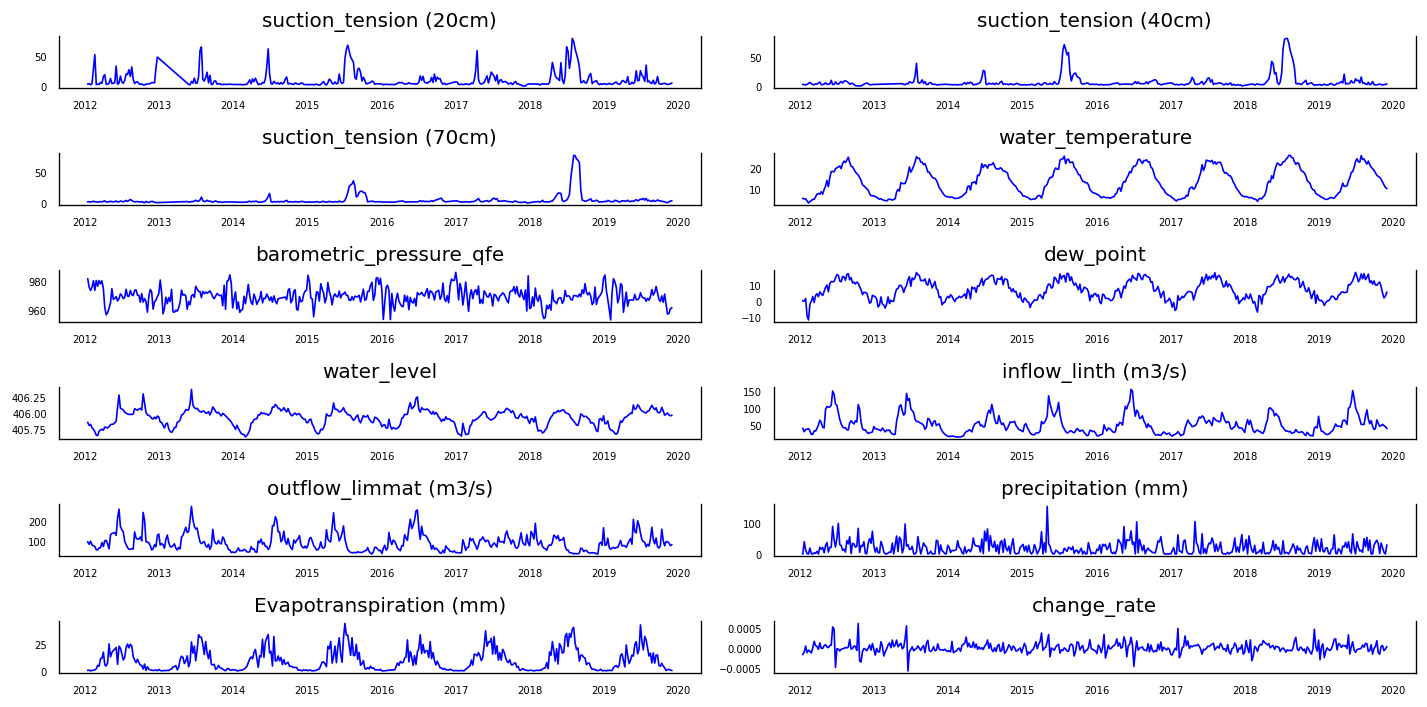

In [33]:
#Plot all variables
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    weekly_data2 = weekly_data[weekly_data.columns[i]]
    ax.plot(weekly_data2, color='blue', linewidth=1)
    # Decorations
    ax.set_title(weekly_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Through the plots we could hypothesize that there is some seasonality. One way to verify it, is through the Augmented Dickey-Fuller (ADF) test.

**2. Testing the stationarity by using ADF and differencing the data**

In [34]:
for name, column in weekly_data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "suction_tension (20cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7781
 No. Lags Chosen       = 4
 Critical value 1%     = -3.447
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (40cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.4793
 No. Lags Chosen       = 6
 Critical value 1%     = -3.447
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (70cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has 

The ADF test states that all variables are stationary. However, since the ACF dropped to zero very slowly, we decide to reject the hypothesys that our data is stationary and we difference it.

In [36]:
#Let's difference the dataset in order to be sure that the data is stationary
weekly_data_differenced = weekly_data.diff().dropna()

**3. Testing cointegration**

Through the cointegration test it is possible to determine important statistical relations between the variables.

In [37]:
cointegration_test(weekly_data_differenced)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
suction_tension (20cm) ::  1646.77   > 311.1288  =>   True
suction_tension (40cm) ::  1394.64   > 263.2603  =>   True
suction_tension (70cm) ::  1188.17   > 219.4051  =>   True
water_temperature ::  998.8     > 179.5199  =>   True
barometric_pressure_qfe ::  819.73    > 143.6691  =>   True
dew_point ::  669.42    > 111.7797  =>   True
water_level ::  532.07    > 83.9383   =>   True
inflow_linth (m3/s) ::  403.67    > 60.0627   =>   True
outflow_limmat (m3/s) ::  285.59    > 40.1749   =>   True
precipitation (mm) ::  179.12    > 24.2761   =>   True
Evapotranspiration (mm) ::  92.62     > 12.3212   =>   True
change_rate ::  19.71     > 4.1296    =>   True


As we can see, all variables are cointegrated.

**4. Split the data into train, validation and test set.**

In [361]:
#Let's keep a copy of the undifferenced train, validation and test sets.
train, test = train_test_split(weekly_data, train_size=365) #train: 2012-2019, test: 2019-2020
train_val, val = train_test_split(train, train_size=312) #train_val: 2012-2018, val: 2018-2019

In [362]:
train_differenced, test_differenced = train_test_split(weekly_data_differenced, train_size=364)

In [363]:
train_val_differenced, val_differenced = train_test_split(train_differenced, train_size=311)

**5. Checking the AIC score**

In [364]:
from statsmodels.tsa.vector_ar.var_model import VAR # imports VAR
model_VAR = VAR(train_val_differenced) # initializes VAR object
model_VAR.select_order(maxlags=10).summary()

,AIC,BIC,FPE,HQIC
0,9.228,9.376,1.018e+04,9.288
1,-7.190,-5.268*,0.0007548,-6.421*
2,-7.736,-4.042,0.0004386,-6.258
3,-7.975*,-2.507,0.0003490*,-5.787
4,-7.949,-0.7067,0.0003658,-5.051
5,-7.770,1.246,0.0004523,-4.162
6,-7.603,3.186,0.0005619,-3.285
7,-7.597,4.965,0.0006065,-2.570
8,-7.678,6.657,0.0006158,-1.942
9,-7.785,8.324,0.0006283,-1.339


From the results, we can see that the lowest AIC is obtained when the lag order is equal to 3.

**6. Testing causality through Granger's causality test**

In [365]:
get_grangers_causation_results(train_differenced, 3, test='ssr_chi2test')

,suction_tension (20cm)_y,suction_tension (40cm)_y,suction_tension (70cm)_y,water_temperature_y,barometric_pressure_qfe_y,dew_point_y,water_level_y,inflow_linth (m3/s)_y,outflow_limmat (m3/s)_y,precipitation (mm)_y,Evapotranspiration (mm)_y,change_rate_y
suction_tension (20cm)_x,1.0000,0.0005,0.0062,0.0302,0.5471,0.4395,0.3296,0.7591,0.2134,0.0132,0.0152,0.5519
suction_tension (40cm)_x,0.0013,1.0000,0.0000,0.8178,0.3768,0.1696,0.2136,0.3271,0.1233,0.0529,0.2196,0.4486
suction_tension (70cm)_x,0.1910,0.0000,1.0000,0.3341,0.4665,0.1218,0.4386,0.9520,0.4543,0.0529,0.0471,0.1309
water_temperature_x,0.3257,0.5618,0.1552,1.0000,0.3882,0.0002,0.0149,0.0262,0.2122,0.3694,0.0714,0.5668
barometric_pressure_qfe_x,0.0187,0.3138,0.7749,0.2407,1.0000,0.0547,0.0442,0.2192,0.0092,0.1130,0.1209,0.0197
dew_point_x,0.0304,0.5036,0.5559,0.0001,0.7074,1.0000,0.0003,0.0000,0.0003,0.6577,0.2094,0.0060
water_level_x,0.4788,0.2146,0.6213,0.0002,0.0306,0.0074,1.0000,0.1138,0.0797,0.0000,0.0005,0.0000
inflow_linth (m3/s)_x,0.8048,0.7056,0.8239,0.0216,0.2597,0.0598,0.2192,1.0000,0.0035,0.0001,0.0413,0.0000
outflow_limmat (m3/s)_x,0.7679,0.7089,0.6315,0.1010,0.0431,0.4200,0.0001,0.0142,1.0000,0.0000,0.0008,0.0000
precipitation (mm)_x,0.0401,0.1682,0.0688,0.0447,0.1573,0.2253,0.0000,0.0000,0.0000,1.0000,0.4153,0.0000


After this analysis we will keep the following variables: water temperature, barometric pressure, dew point, outflow, precipitation, evapotranspiration and change rate.

**7.1 Fitting the model with Walking Forward**

Here are the results with the walking forward method.

In [366]:
VAR_wf_we_test_diff, VAR_wf_we_val_diff = walk_forward_VAR(train_val_differenced, val_differenced, 3, weekly_data)
train_wf_validation_inverted = invert_transformation(train_val, VAR_wf_we_test_diff, first_diff=True)
wf_validation_inverted = invert_transformation(train_val, VAR_wf_we_val_diff, first_diff=True)

**7.2 Fitting the model without walking forward method**

In [367]:
#Fit the model and forecast for a certain number of steps
forecast_input = train_val_differenced.values[-18:]
model_fitted = VAR(train_val_differenced).fit(18)
fc = model_fitted.forecast(y=forecast_input, steps=52)
VAR_we_val = pd.DataFrame(fc, index=train.index[-52:], columns=train.columns)

In [368]:
#Invert the transformation
we_val_inverted = invert_transformation(train_val, VAR_we_val, first_diff=True)

<AxesSubplot: xlabel='datetime'>

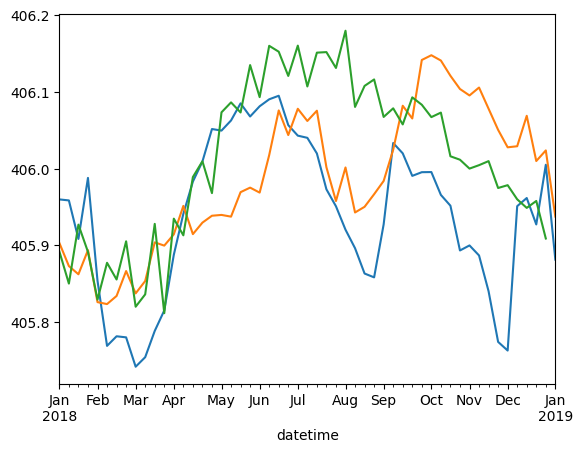

In [369]:
train_wf_validation_inverted["water_level"].plot()
wf_validation_inverted["water_level"].plot()
we_val_inverted["water_level"].plot()

# VAR Model - Monthly data, all variables

In [92]:
#Let's drop all NAN values
monthly_data = monthly_data.dropna()

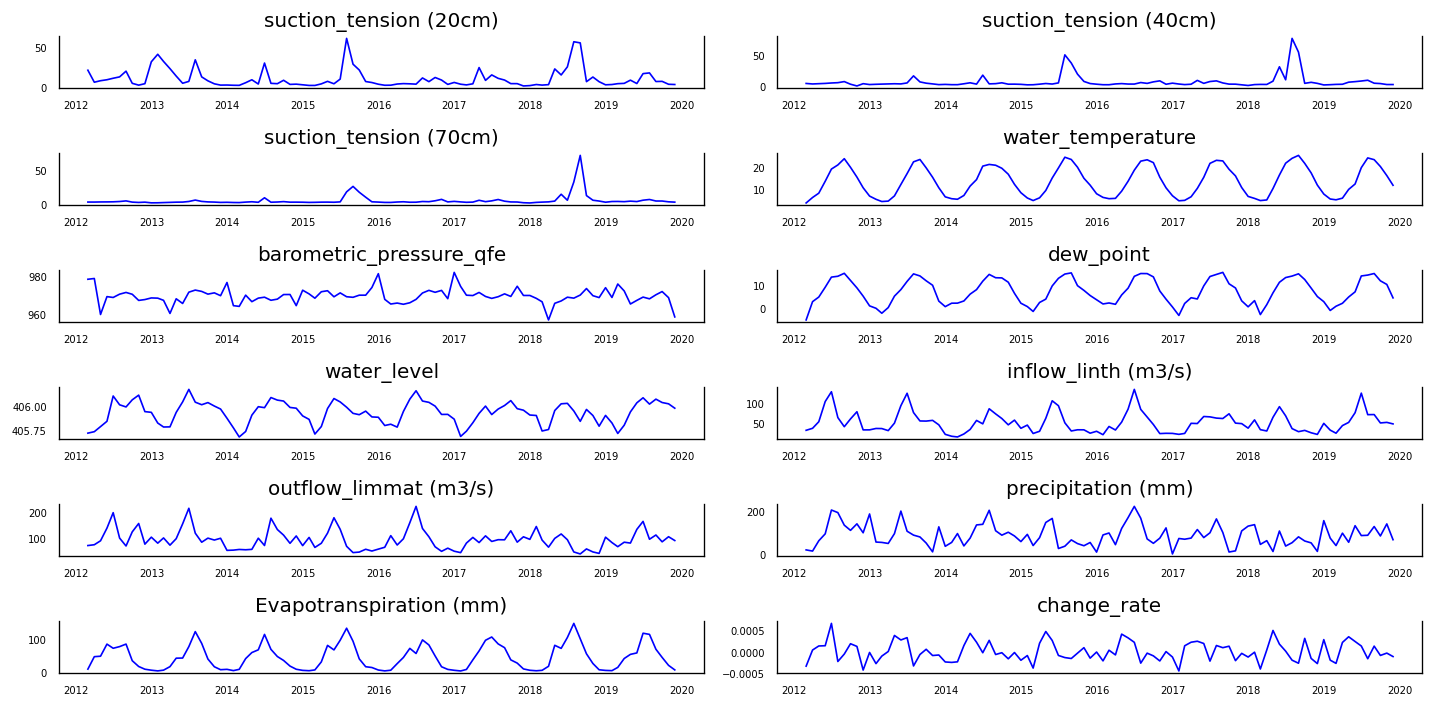

In [93]:
#Plot all variables
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    monthly_data2 = monthly_data[monthly_data.columns[i]]
    ax.plot(monthly_data2, color='blue', linewidth=1)
    # Decorations
    ax.set_title(monthly_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

**2. Testing the stationarity by using ADF and differencing the data**

In [94]:
for name, column in monthly_data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "suction_tension (20cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.569
 No. Lags Chosen       = 0
 Critical value 1%     = -3.503
 Critical value 5%     = -2.893
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (40cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.5539
 No. Lags Chosen       = 0
 Critical value 1%     = -3.503
 Critical value 5%     = -2.893
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (70cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit

As we can see, evapotranspiration, water level and dew point are non-stationary. We need to difference the data.

In [95]:
#Let's difference the dataset in order to be sure that the data is stationary
monthly_data_differenced = monthly_data.diff().dropna()

In [96]:
#Let's test stationarity again.
for name, column in monthly_data_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "suction_tension (20cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.776
 No. Lags Chosen       = 1
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (40cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.2301
 No. Lags Chosen       = 1
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (70cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit

Now all variables are stationary. We can therefore continue with the next step.

**3. Testing cointegration**

In [97]:
cointegration_test(monthly_data_differenced)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
suction_tension (20cm) ::  1619.14   > 311.1288  =>   True
suction_tension (40cm) ::  1195.15   > 263.2603  =>   True
suction_tension (70cm) ::  898.22    > 219.4051  =>   True
water_temperature ::  616.98    > 179.5199  =>   True
barometric_pressure_qfe ::  424.53    > 143.6691  =>   True
dew_point ::  292.89    > 111.7797  =>   True
water_level ::  194.68    > 83.9383   =>   True
inflow_linth (m3/s) ::  118.03    > 60.0627   =>   True
outflow_limmat (m3/s) ::  67.87     > 40.1749   =>   True
precipitation (mm) ::  38.73     > 24.2761   =>   True
Evapotranspiration (mm) ::  20.95     > 12.3212   =>   True
change_rate ::  9.05      > 4.1296    =>   True


We can see that now all variables are cointegrating.

**4. Split the data into train, validation and test set.**

In [402]:
#Let's keep a copy of the undifferenced train, validation and test sets.
train_mo, test_mo = train_test_split(monthly_data, train_size=83) #train: 2012-(end of) 2018, test: 2019-(end of) 2019
train_val_mo, val_mo = train_test_split(train_mo, train_size=71) #train_val: 2012-(end of) 2017, val: 2018-(end of) 2018

In [442]:
#Let's now make train; validation and tests sets with the differenced data.
train_mo_differenced, test_mo_differenced = train_test_split(monthly_data_differenced, train_size=82)

In [376]:
train_val_mo_differenced, val_mo_differenced = train_test_split(train_mo_differenced, train_size=70)

**5. Checking the AIC score**

In [377]:
model_mo_VAR = VAR(train_val_mo_differenced) # initializes VAR object
model_mo_VAR.select_order(maxlags=4).summary()

,AIC,BIC,FPE,HQIC
0,16.00,16.39,8.852e+06,16.15
1,-2.871,2.304,0.06028,-0.8262
2,-4.610,5.343,0.01603,-0.6770
3,-8.457,6.274,0.001228,-2.636
4,-19.96*,-0.4482*,3.613e-07*,-12.25*


The minimum AIC is at lag 4. We are therefore going to select it.

Fitting the model

In [436]:
VAR_wf_mo_test_diff, VAR_wf_mo_val_diff = walk_forward_VAR(train_val_mo_differenced, val_mo_differenced, 1, monthly_data)

In [437]:
train_wf_mo_validation_inverted = invert_transformation(train_val_mo, VAR_wf_mo_test_diff, first_diff=True)
wf_mo_validation_inverted = invert_transformation(train_val_mo, VAR_wf_mo_val_diff, first_diff=True)

<AxesSubplot: xlabel='datetime'>

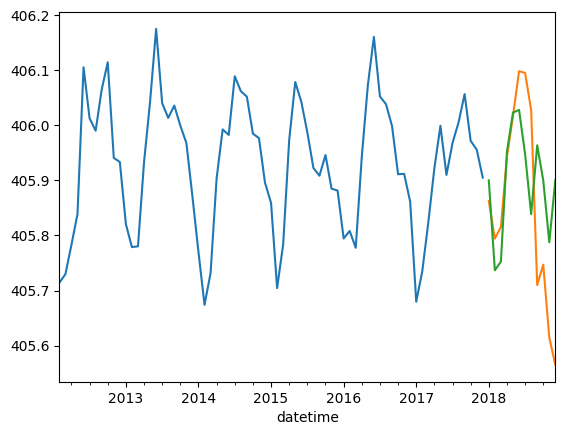

In [438]:
train_val_mo["water_level"].plot()
wf_mo_validation_inverted["water_level"].plot()
train_wf_mo_validation_inverted["water_level"].plot()

In [417]:
#Fit the model and forecast for a certain number of steps
forecast_input = train_val_mo_differenced.values[-3:]
model_fitted = VAR(train_val_mo_differenced).fit(3)
fc = model_fitted.forecast(y=forecast_input, steps=12)
VAR_mo_val = pd.DataFrame(fc, index=train_mo.index[-12:], columns=train_mo.columns)

In [415]:
mo_val_inverted = invert_transformation(train_val_mo, VAR_mo_val, first_diff=True)

<AxesSubplot: xlabel='datetime'>

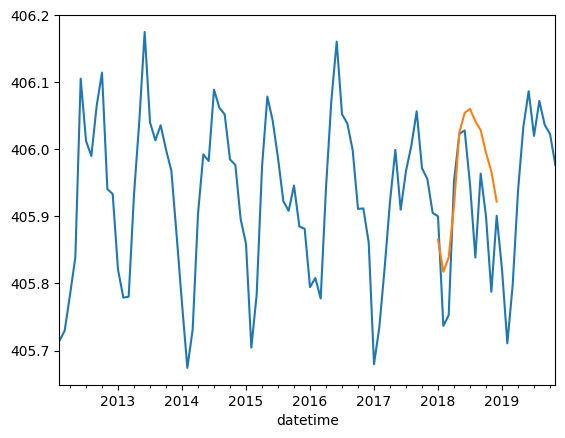

In [416]:
monthly_data["water_level"].plot()
mo_val_inverted["water_level"].plot()

In [203]:
def mape(df_true, df_pred, epsilon=1e-4):
    # replacing every occurence of zero in the true values with epsilon
    df_true[df_true == 0] = epsilon 
    
    error = df_true - df_pred # calculates the error
    
    return 100 * np.mean(np.abs(error/df_true), axis=0) # resturns the MAPE
 
# importing mean square error
from sklearn.metrics import mean_squared_error as mse

# defining a function to return a dataframe of rmse and mape scores
def get_rmse_and_mape(df_true, df_pred):
    results = {'RMSE': mse(np.array(df_true), np.array(df_pred), multioutput='raw_values', squared=False), 
               'MAPE (%)': mape(np.array(df_true), np.array(df_pred))}
    
    return pd.DataFrame(results, index=df_true.columns)

In [204]:
get_rmse_and_mape(train_wf_mo_validation_inverted, wf_mo_validation_inverted)

,RMSE,MAPE (%)
suction_tension (20cm),66.727907,730.573385
suction_tension (40cm),124.524720,2117.392813
suction_tension (70cm),85.582754,1198.263588
water_temperature,3.682915,23.887434
barometric_pressure_qfe,19.652437,1.647321
dew_point,5.812877,103.366012
water_level,0.195719,0.039813
inflow_linth (m3/s),54.854382,117.706376
outflow_limmat (m3/s),123.350834,145.929617
precipitation (mm),381.344512,710.308978


In [ ]:
def mean_errors(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    MAE = mae(actual, pred)
    MSE = np.square(np.subtract(actual,pred)).mean()
    MAPE = np.mean(np.abs((actual - pred) / actual)) * 100
    R2_score = r2_score(actual, pred)
    return print("MAE: {} \nMSE: {} \nMAPE: {} \nR2: {}".format(MAE, MSE, MAPE, R2_score))

In [147]:
mean_errors(train_wf_mo_validation_inverted["water_level"], wf_mo_validation_inverted["water_level"])

MAE: 0.11942225306085656 
MSE: 0.022133169594024005 
MAPE: 0.02942200579374849 
R2: -1.5277318846877561
